In [36]:
%matplotlib inline
import numpy as np
import matplotlib
import os
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from colorsys import rgb_to_hls
from PIL import Image
from scipy.stats import stats
from sklearn.utils import shuffle
sns.set(font_scale=1.5, style="whitegrid", color_codes=True)
plt.rcParams['figure.figsize'] = (16, 12)

In [2]:
data_dir = "/home/dat/Workspace/Thesis/lettuce_predictor/data/rasters_csv"

## Load data and calculate indices

In [3]:
df = pd.DataFrame()
for fname in os.listdir(data_dir):
    if fname.endswith("csv"):
         df = df.append(pd.read_csv(os.path.join(data_dir, fname)), ignore_index=True)
            
df.describe()

,Nitrogen,Irrigation,Replication,Plant Number,Chlorophyll,NDVI,WP,Average Height,Average Leaf Count
count,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,240.000000,480.000000,480.000000
mean,43.750000,43.750000,2.000000,187.400000,43.515833,0.811986,-1.774208,15.458333,14.758333
std,37.014075,37.014075,0.817348,39.776075,6.090281,0.043860,1.466062,5.858307,5.172588
min,0.000000,0.000000,1.000000,104.000000,1.200000,0.126831,-4.950000,4.000000,5.000000
25%,18.750000,18.750000,1.000000,201.000000,39.775000,0.795598,-2.710000,11.000000,11.000000
50%,37.500000,37.500000,2.000000,203.500000,43.400000,0.816542,-1.165000,15.000000,15.000000
75%,62.500000,62.500000,3.000000,211.000000,47.625000,0.836362,-0.740000,19.000000,19.000000
max,100.000000,100.000000,3.000000,214.000000,60.900000,0.876963,-0.400000,35.000000,25.000000


In [4]:
EPSILON = 1e-10

def NDVI(R, NIR):
    return (NIR - R) / (NIR + R + EPSILON)

def RedEdge(R, RE):
    return RE / (R + EPSILON)

def EVI(B, R, NIR):
    return 2.5 * (NIR - R) / (NIR + EPSILON) + 6 * R - 7.5 * B + 1 

def MCARI(G, R, RE):
    return (RE - R) - 0.23 * (RE - G) * RE / (R + EPSILON)

def GNDVI(G, NIR):
    return (NIR - G) / (NIR + G + EPSILON)

def DGCI(H, L, S):
    return ((H - 60) / 60 + (1 - S) + (1 - L)) / 3

In [5]:
channel_vals = []
for id, row in df.iterrows():
    raster = np.load(row["img_path"])
    # Crop border to only get plant in image
    # raster = raster[1:-1, 1:-1]
    b, g, r, re, nir = np.mean(raster, axis=(0, 1))
    channel_vals.append([b, g, r, re, nir])
    
df["channel_vals"] = channel_vals

In [6]:
ndvi, rededge, evi, mcari, gndvi, dgci, channel_vals = [], [], [], [], [], [], []
for id, row in df.iterrows():
    raster = np.load(row["img_path"])
    b, g, r, re, nir = np.mean(raster, axis=(0, 1))
    ndvi.append(NDVI(r, nir))
    rededge.append(RedEdge(r, re))
    evi.append(EVI(b, r, nir))
    mcari.append(MCARI(g, r, re))
    gndvi.append(GNDVI(g, nir))
    # channel_vals.append([b, g, r, re, nir])
    channel_vals.append([b, g, r])
    hls = np.zeros((raster.shape[0], raster.shape[1], 3))
    for i in range(raster.shape[0]):
        for j in range(raster.shape[1]):
            hls[i, j] = rgb_to_hls(raster[i,j,2], raster[i,j,1], raster[i,j,0])
    h, l, s = np.mean(hls, axis=(0, 1))
    dgci.append(DGCI(h, l, s))
    
df["UAV_NDVI"] = ndvi
df["RedEdge"] = rededge
df["EVI"] = evi
df["MCARI"] = mcari
df["GNDVI"] = gndvi
df["DGCI"] = dgci
df["channel_vals"] = channel_vals

In [7]:
df.head()

,Nitrogen,Irrigation,Replication,Plant Number,Chlorophyll,NDVI,WP,Average Height,Average Leaf Count,img_path,channel_vals,UAV_NDVI,RedEdge,EVI,MCARI,GNDVI,DGCI
0,0,0,1,104,48.9,0.805878,-4.80,6,7,/home/dat/Workspace/Thesis/lettuce_predictor/d...,"[0.24857644703653123, 0.34114080948962106, 0.2...",0.306257,1.838879,1.535207,0.156789,0.060578,0.159316
1,0,0,1,113,44.4,0.815393,NaN,6,7,/home/dat/Workspace/Thesis/lettuce_predictor/d...,"[0.23450525974233946, 0.36158036161214113, 0.1...",0.415285,2.271345,1.822472,0.204634,0.108342,0.136695
2,0,0,2,104,48.8,0.839747,-4.24,4,6,/home/dat/Workspace/Thesis/lettuce_predictor/d...,"[0.25269621460124697, 0.37957831374322526, 0.2...",0.318001,1.958353,1.631385,0.187752,0.056731,0.146103
3,0,0,2,113,53.5,0.819832,NaN,4,6,/home/dat/Workspace/Thesis/lettuce_predictor/d...,"[0.21367022653038686, 0.33464863523840904, 0.1...",0.419148,2.209147,1.955270,0.185652,0.136224,0.149958
4,0,0,3,104,51.9,0.812323,-4.82,7,6,/home/dat/Workspace/Thesis/lettuce_predictor/d...,"[0.15233559229157187, 0.24997904659672218, 0.1...",0.533825,2.555669,2.454615,0.154571,0.305527,0.176331


In [8]:
ndvi_values = list(df["UAV_NDVI"].values)

print("Average: %.4f" % np.average(ndvi_values))
print("Std Dev: %.4f" % np.std(ndvi_values))

Average: 0.4787
Std Dev: 0.0866


In [37]:
def create_scatter(x, y, x_title, y_title):
    x, y = shuffle(x, y)
    x = x[:100]
    y = y[:100]
    fig = plt.figure()
    sns.regplot(x=x, y=y, fit_reg=False, label="big")
    plt.xlabel(x_title)
    plt.ylabel(y_title)
    plt.savefig("{}_{}.png".format(x_title.replace(" ", "_"), y_title.replace(" ", "_")))

In [38]:
print("NDVI & WP:", stats.pearsonr(df.dropna()["UAV_NDVI"], df.dropna()["WP"])[0])
print("RedEdge & WP:", stats.pearsonr(df.dropna()["RedEdge"], df.dropna()["WP"])[0])
print("EVI & WP:", stats.pearsonr(df.dropna()["EVI"], df.dropna()["WP"])[0])
print("MCARI & WP:", stats.pearsonr(df.dropna()["MCARI"], df.dropna()["WP"])[0])
print("GNDVI & WP:", stats.pearsonr(df.dropna()["GNDVI"], df.dropna()["WP"])[0])
print("DGCI & WP:", stats.pearsonr(df.dropna()["DGCI"], df.dropna()["WP"])[0])

NDVI & WP: 0.1705468006219702
RedEdge & WP: 0.08969201730784886
EVI & WP: 0.2265986624057483
MCARI & WP: -0.06086209277716925
GNDVI & WP: 0.14811361311598326
DGCI & WP: 0.036644797843709526


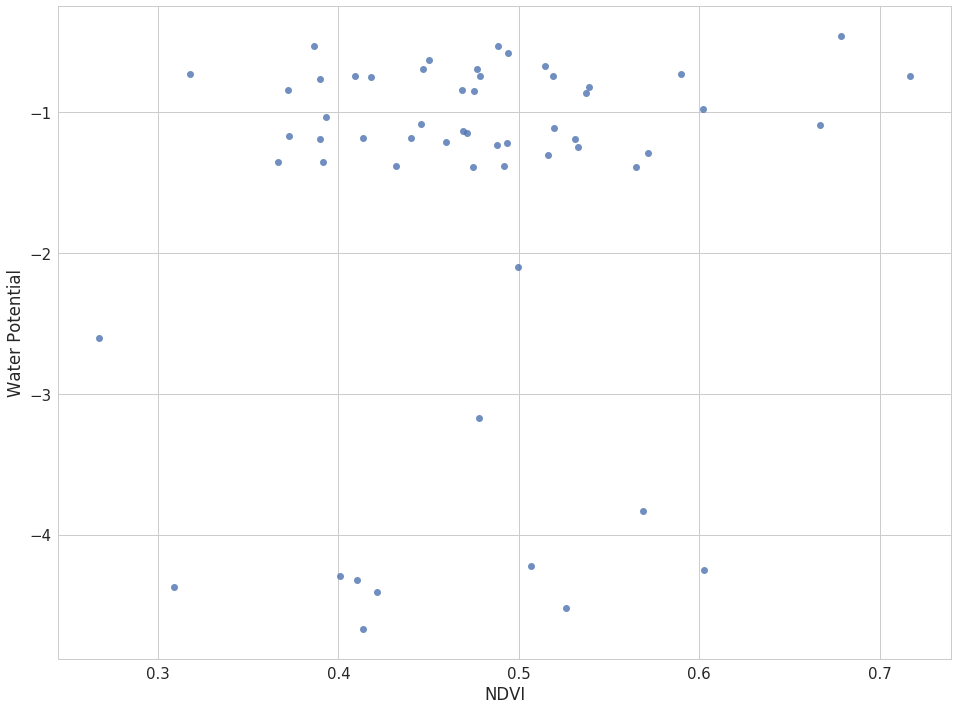

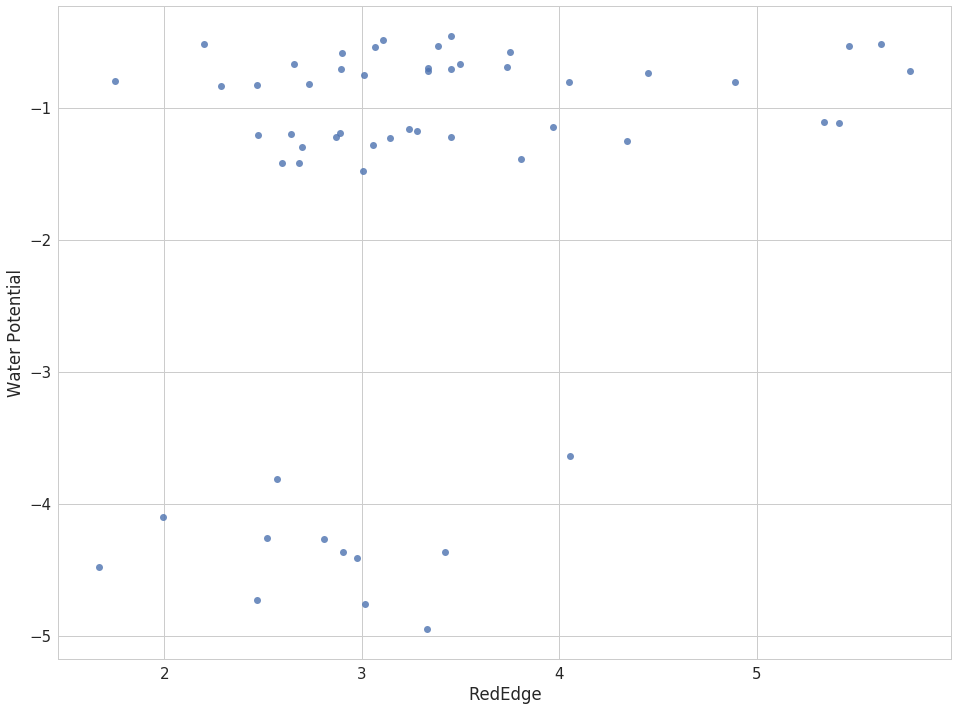

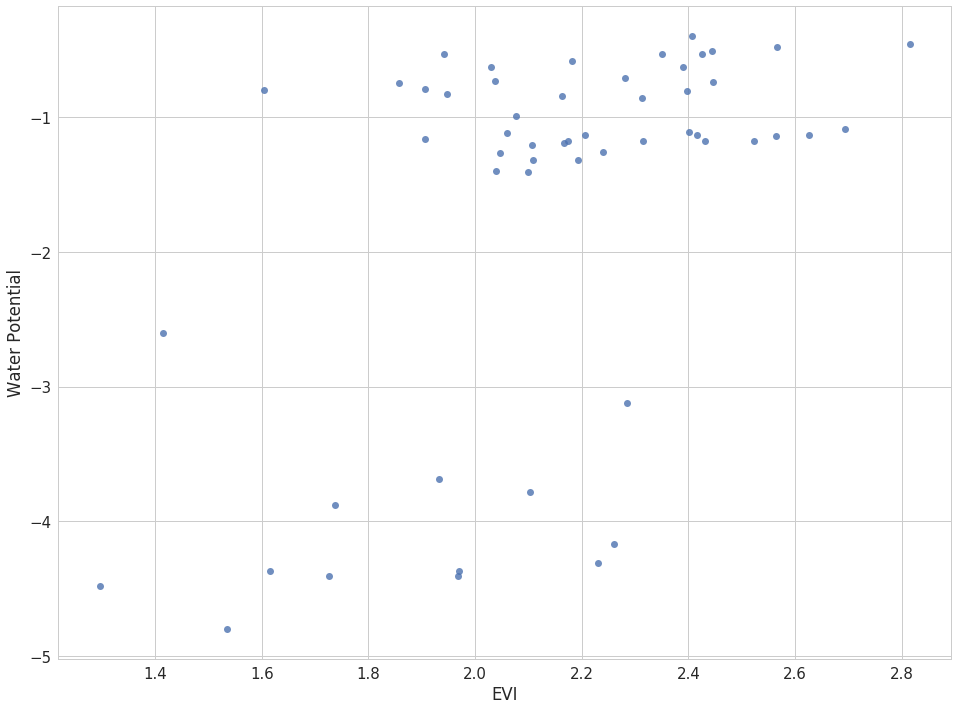

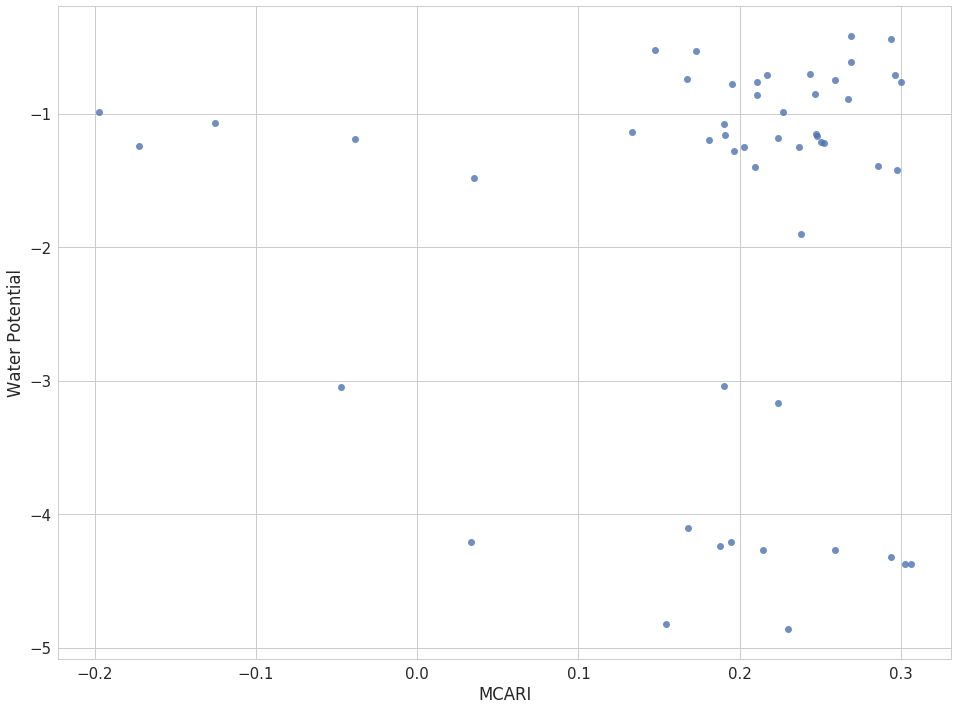

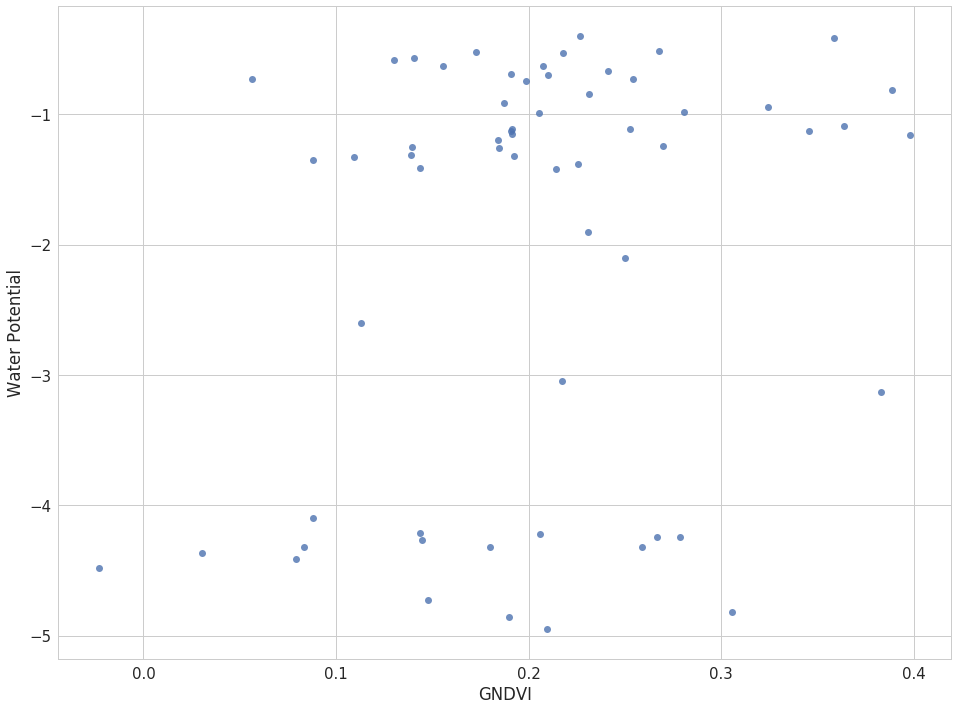

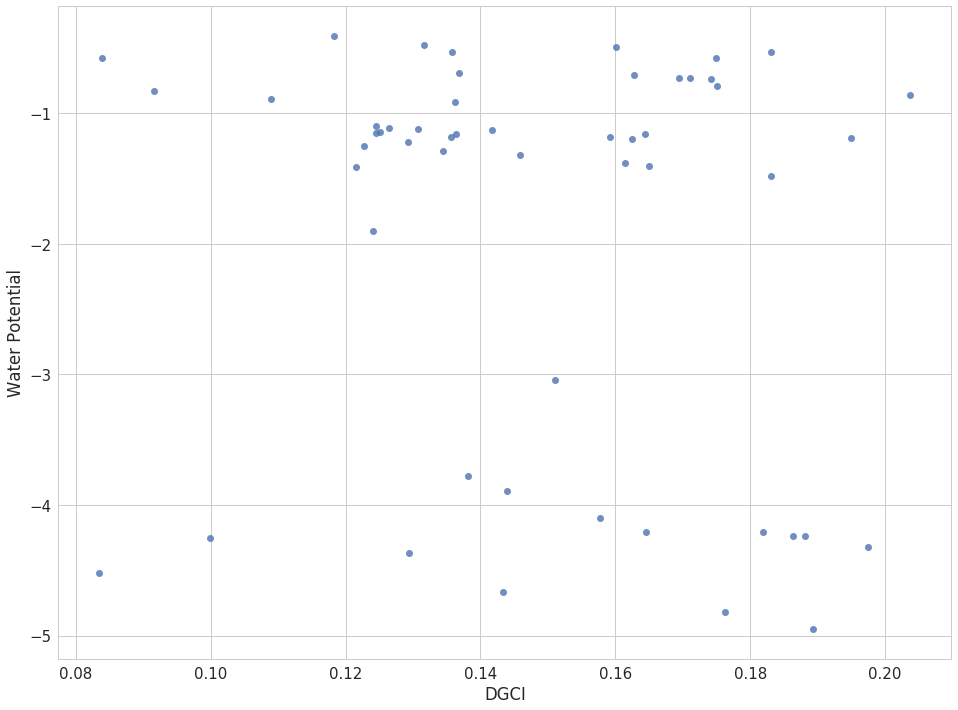

In [39]:
create_scatter(df["UAV_NDVI"], df["WP"], "NDVI", "Water Potential")
create_scatter(df["RedEdge"], df["WP"], "RedEdge", "Water Potential")
create_scatter(df["EVI"], df["WP"], "EVI", "Water Potential")
create_scatter(df["MCARI"], df["WP"], "MCARI", "Water Potential")
create_scatter(df["GNDVI"], df["WP"], "GNDVI", "Water Potential")
create_scatter(df["DGCI"], df["WP"], "DGCI", "Water Potential")

In [40]:
print("NDVI & Chlorophyll:", stats.pearsonr(df["UAV_NDVI"], df["Chlorophyll"])[0])
print("RedEdge & Chlorophyll:", stats.pearsonr(df["RedEdge"], df["Chlorophyll"])[0])
print("EVI & Chlorophyll:", stats.pearsonr(df["EVI"], df["Chlorophyll"])[0])
print("MCARI & Chlorophyll:", stats.pearsonr(df["MCARI"], df["Chlorophyll"])[0])
print("GNDVI & Chlorophyll:", stats.pearsonr(df["GNDVI"], df["Chlorophyll"])[0])
print("DGCI & Chlorophyll:", stats.pearsonr(df["DGCI"], df["Chlorophyll"])[0])

NDVI & Chlorophyll: 0.23589917335900068
RedEdge & Chlorophyll: -0.04451741493525891
EVI & Chlorophyll: 0.09169249361898169
MCARI & Chlorophyll: 0.02718440236529394
GNDVI & Chlorophyll: 0.130958993118054
DGCI & Chlorophyll: -0.044410956317184586


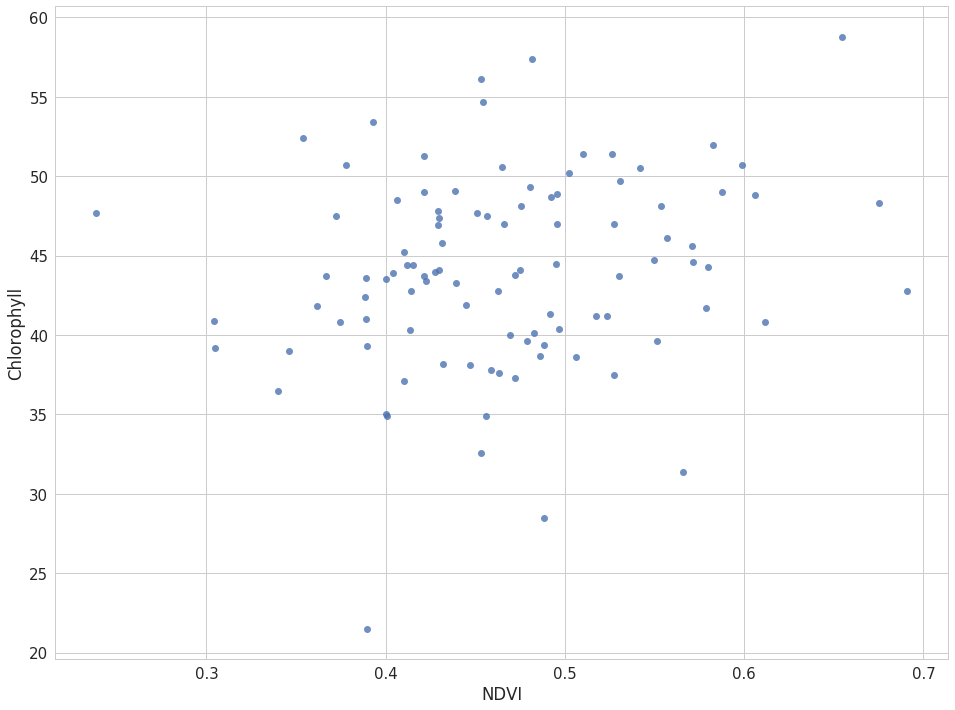

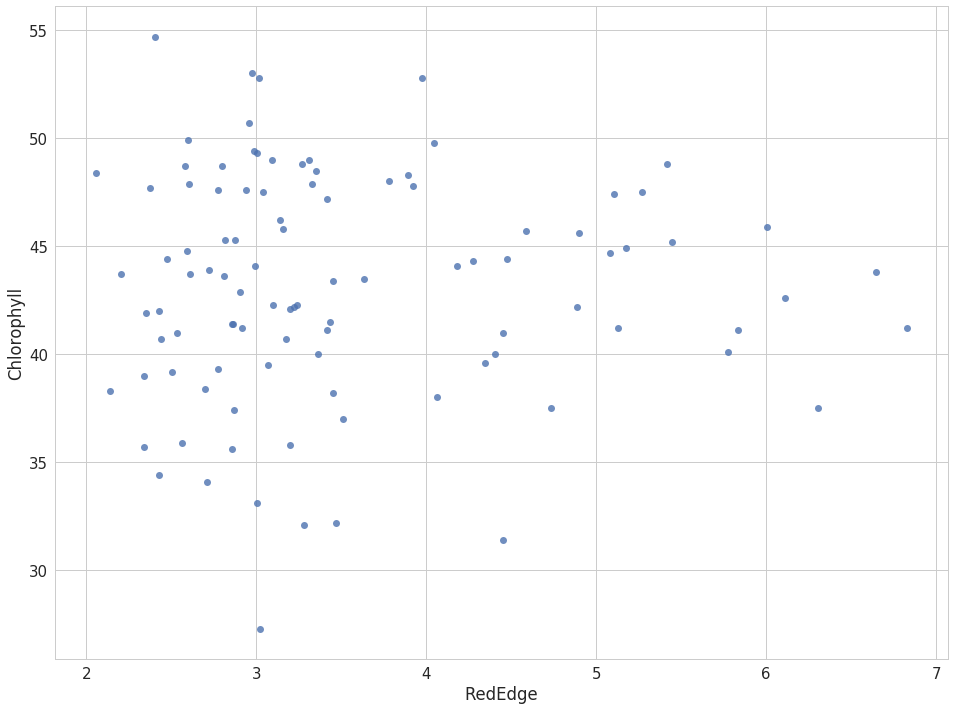

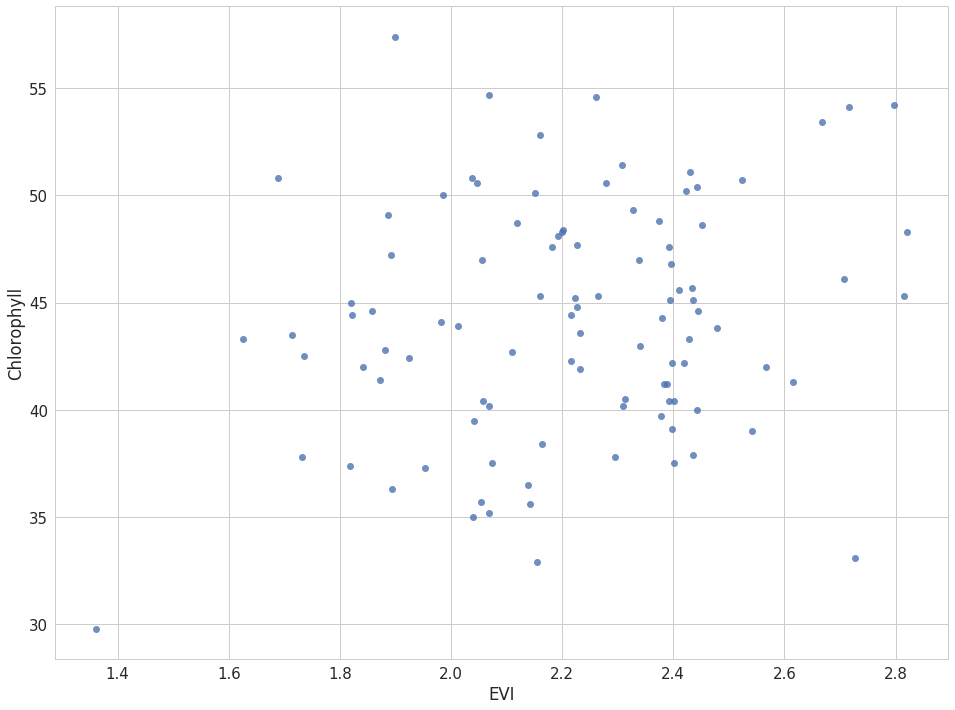

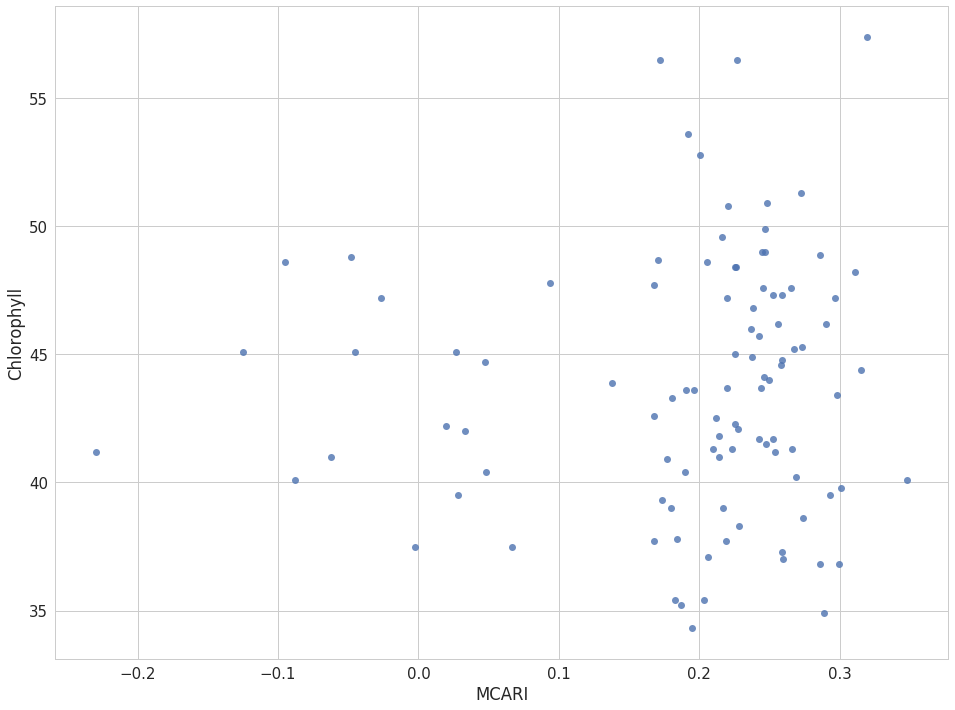

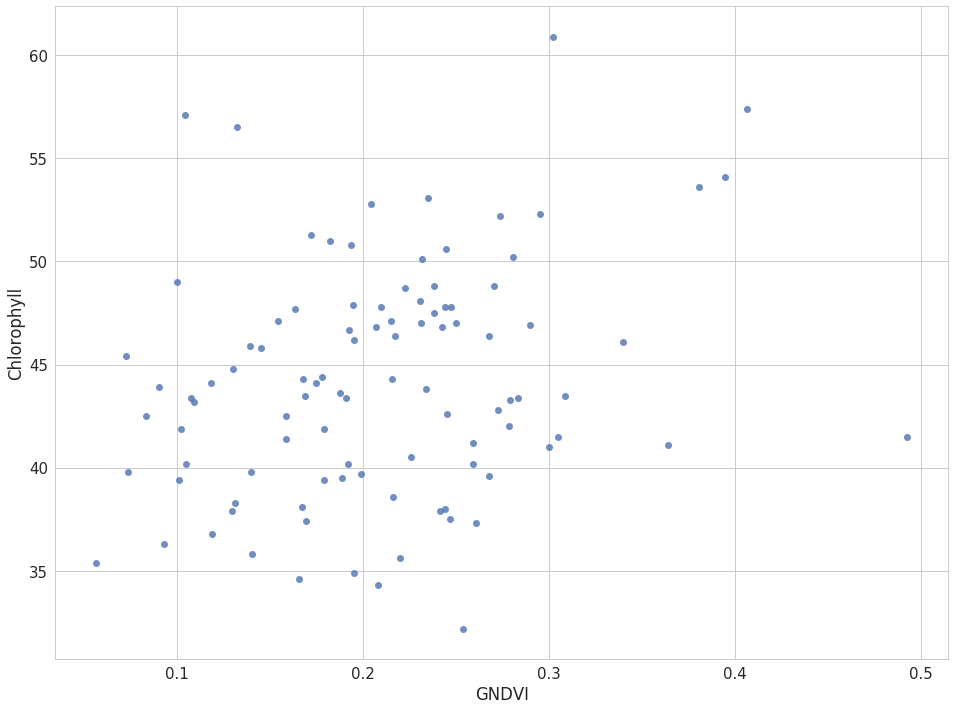

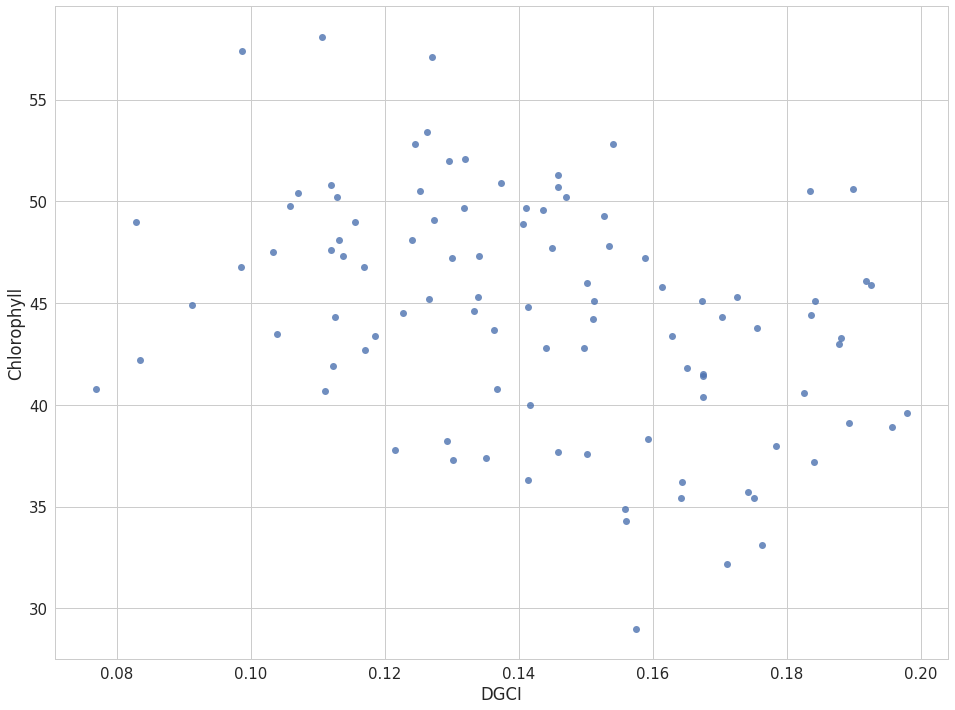

In [44]:
create_scatter(df["UAV_NDVI"], df["Chlorophyll"], "NDVI", "Chlorophyll")
create_scatter(df["RedEdge"], df["Chlorophyll"], "RedEdge", "Chlorophyll")
create_scatter(df["EVI"], df["Chlorophyll"], "EVI", "Chlorophyll")
create_scatter(df["MCARI"], df["Chlorophyll"], "MCARI", "Chlorophyll")
create_scatter(df["GNDVI"], df["Chlorophyll"], "GNDVI", "Chlorophyll")
create_scatter(df["DGCI"], df["Chlorophyll"], "DGCI", "Chlorophyll")

In [45]:
print("NDVI & Average Height:", stats.pearsonr(df["UAV_NDVI"], df["Average Height"])[0])
print("RedEdge & Average Height:", stats.pearsonr(df["RedEdge"], df["Average Height"])[0])
print("EVI & Average Height:", stats.pearsonr(df["EVI"], df["Average Height"])[0])
print("MCARI & Average Height:", stats.pearsonr(df["MCARI"], df["Average Height"])[0])
print("GNDVI & Average Height:", stats.pearsonr(df["GNDVI"], df["Average Height"])[0])
print("DGCI & Average Height:", stats.pearsonr(df["DGCI"], df["Average Height"])[0])

NDVI & Average Height: -0.11838729298856489
RedEdge & Average Height: 0.39332180095589175
EVI & Average Height: 0.2681166154961688
MCARI & Average Height: -0.2415227804970794
GNDVI & Average Height: 0.15048608829583832
DGCI & Average Height: 0.32462467319863214


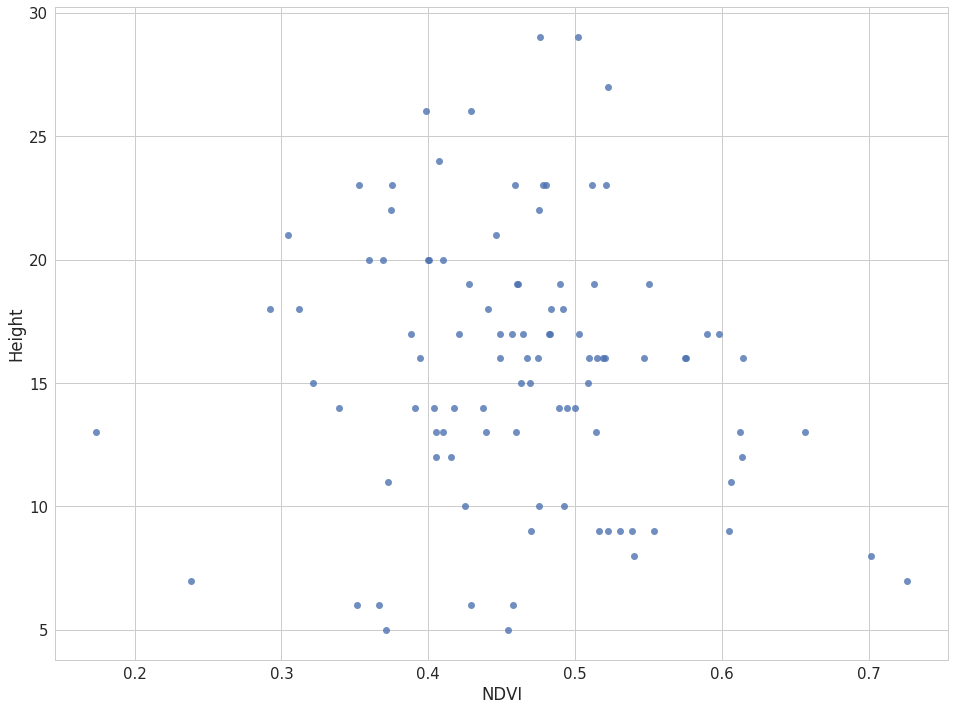

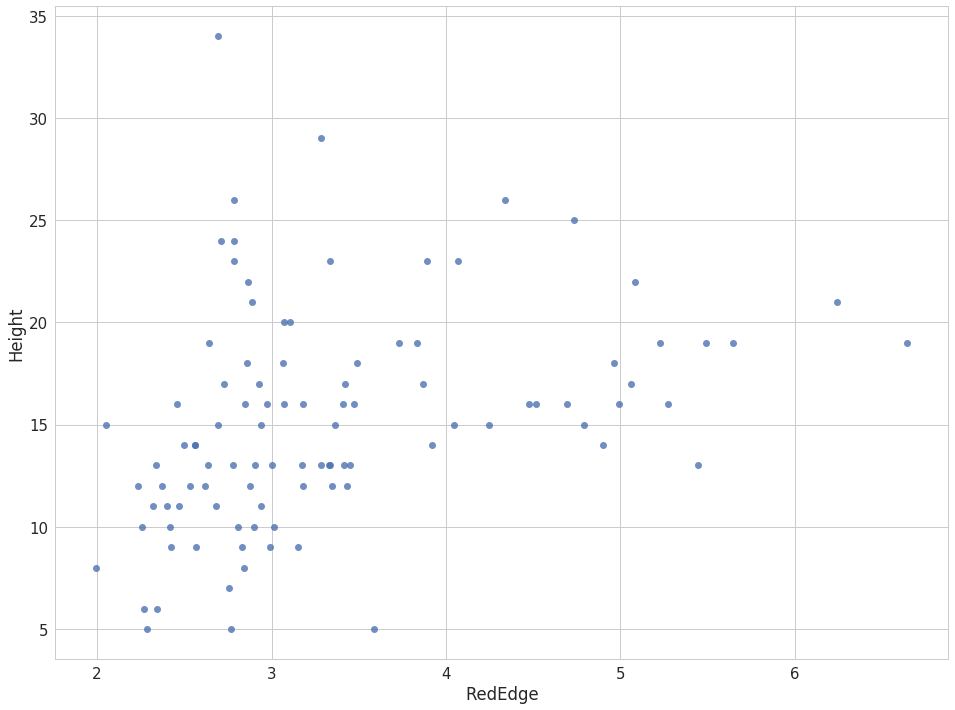

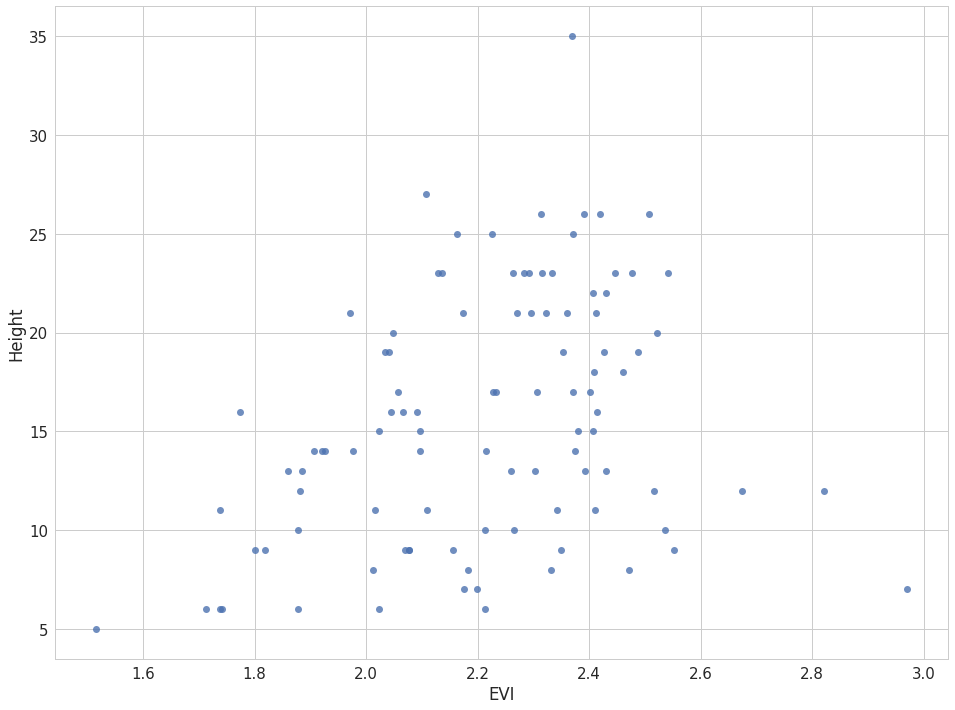

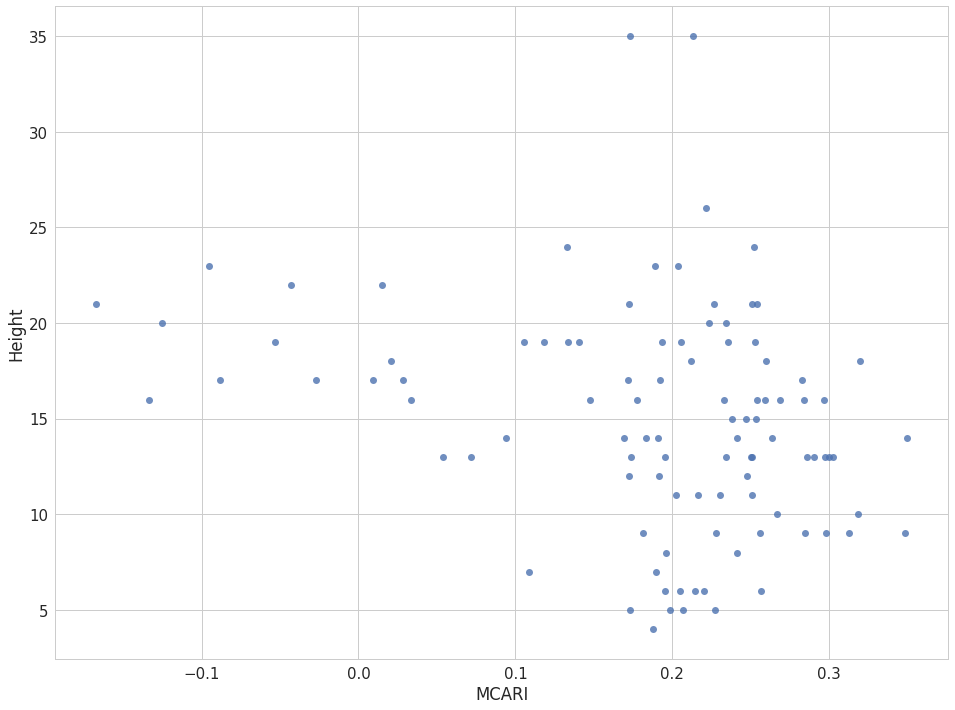

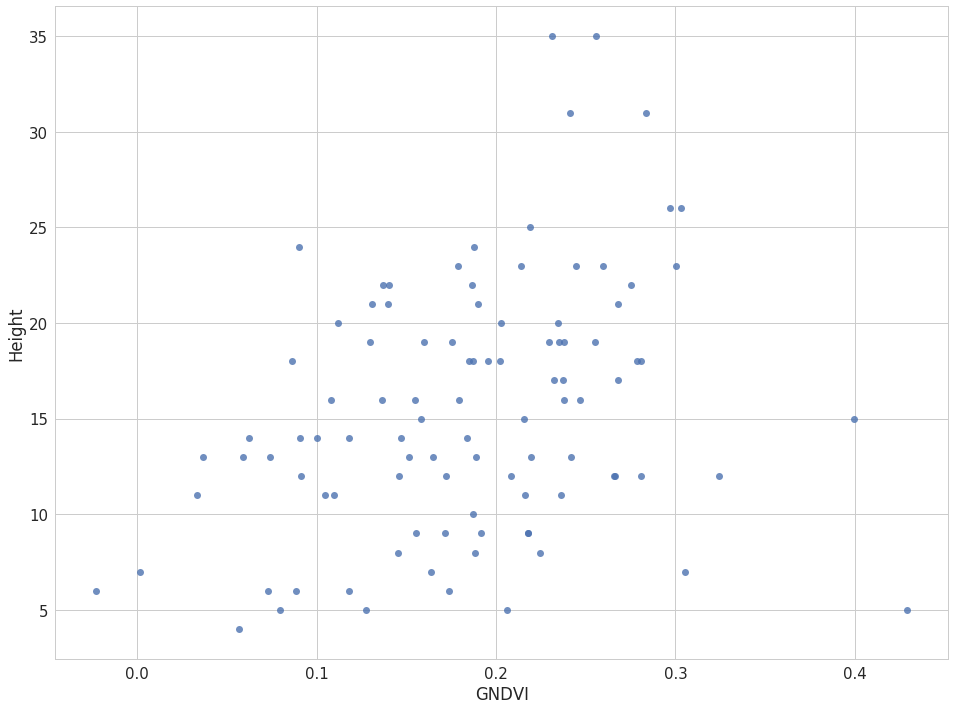

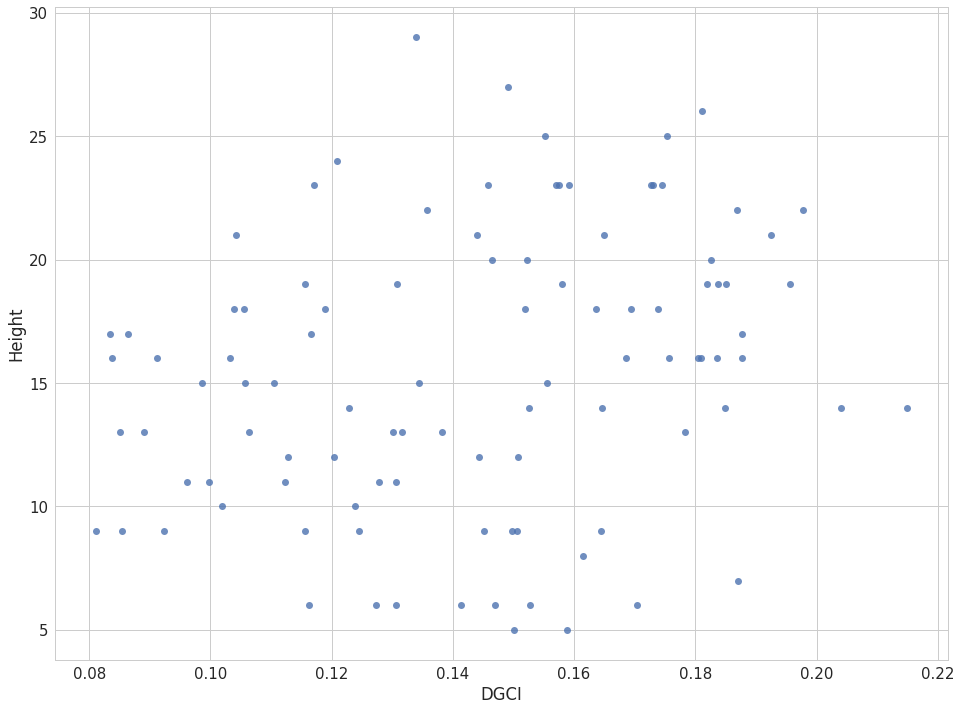

In [46]:
create_scatter(df["UAV_NDVI"], df["Average Height"], "NDVI", "Height")
create_scatter(df["RedEdge"], df["Average Height"], "RedEdge", "Height")
create_scatter(df["EVI"], df["Average Height"], "EVI", "Height")
create_scatter(df["MCARI"], df["Average Height"], "MCARI", "Height")
create_scatter(df["GNDVI"], df["Average Height"], "GNDVI", "Height")
create_scatter(df["DGCI"], df["Average Height"], "DGCI", "Height")

In [47]:
print("NDVI & Average Leaf Count:", stats.pearsonr(df["UAV_NDVI"], df["Average Leaf Count"])[0])
print("RedEdge & Average Leaf Count:", stats.pearsonr(df["RedEdge"], df["Average Leaf Count"])[0])
print("EVI & Average Leaf Count:", stats.pearsonr(df["EVI"], df["Average Leaf Count"])[0])
print("MCARI & Average Leaf Count:", stats.pearsonr(df["MCARI"], df["Average Leaf Count"])[0])
print("GNDVI & Average Leaf Count:", stats.pearsonr(df["GNDVI"], df["Average Leaf Count"])[0])
print("DGCI & Average Leaf Count:", stats.pearsonr(df["DGCI"], df["Average Leaf Count"])[0])

NDVI & Average Leaf Count: -0.20583412863433423
RedEdge & Average Leaf Count: 0.3882790818263001
EVI & Average Leaf Count: 0.1780913779430707
MCARI & Average Leaf Count: -0.2786591822427481
GNDVI & Average Leaf Count: 0.09161515713105689
DGCI & Average Leaf Count: 0.3624660979108142


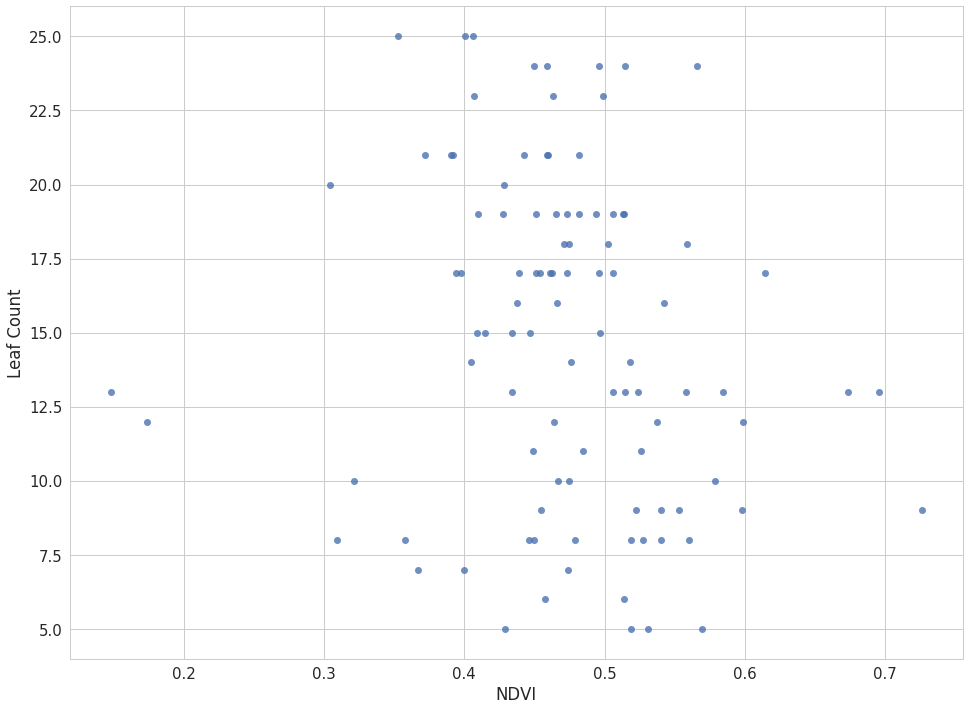

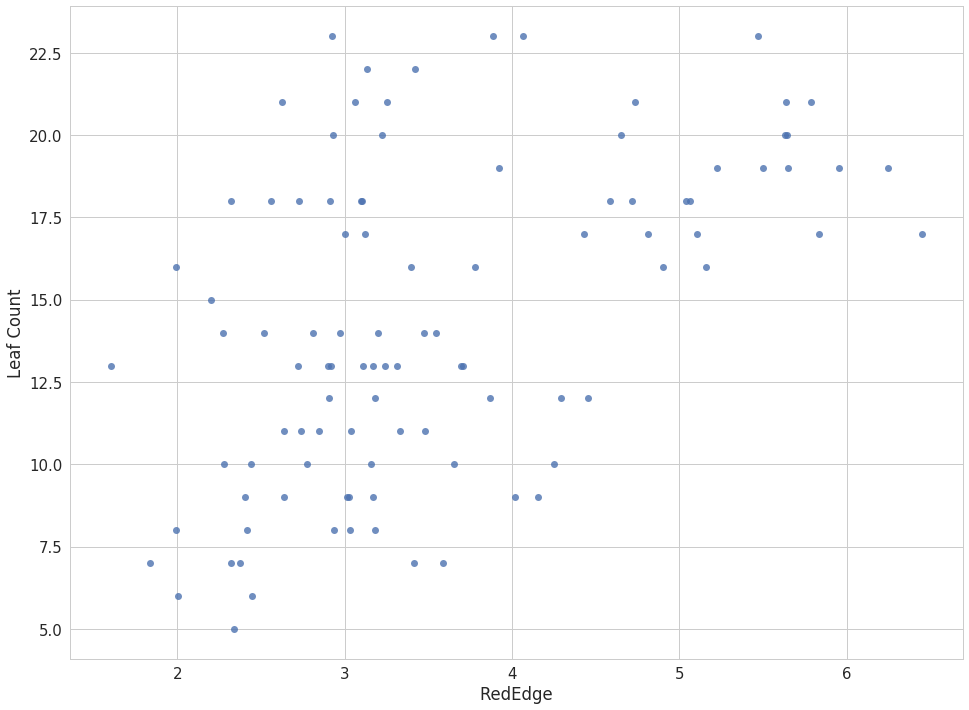

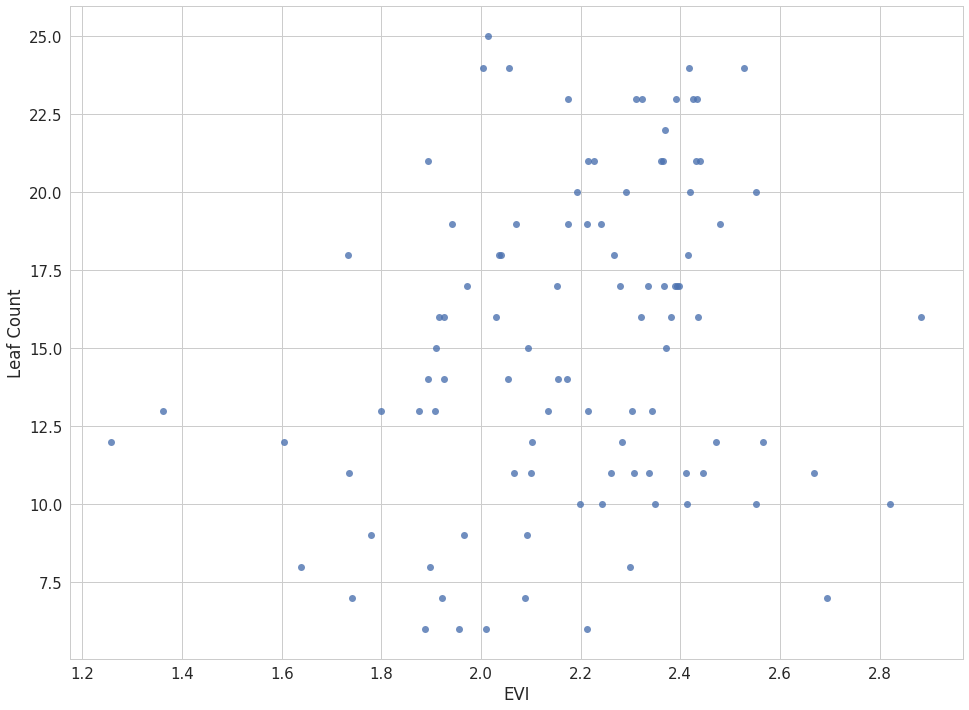

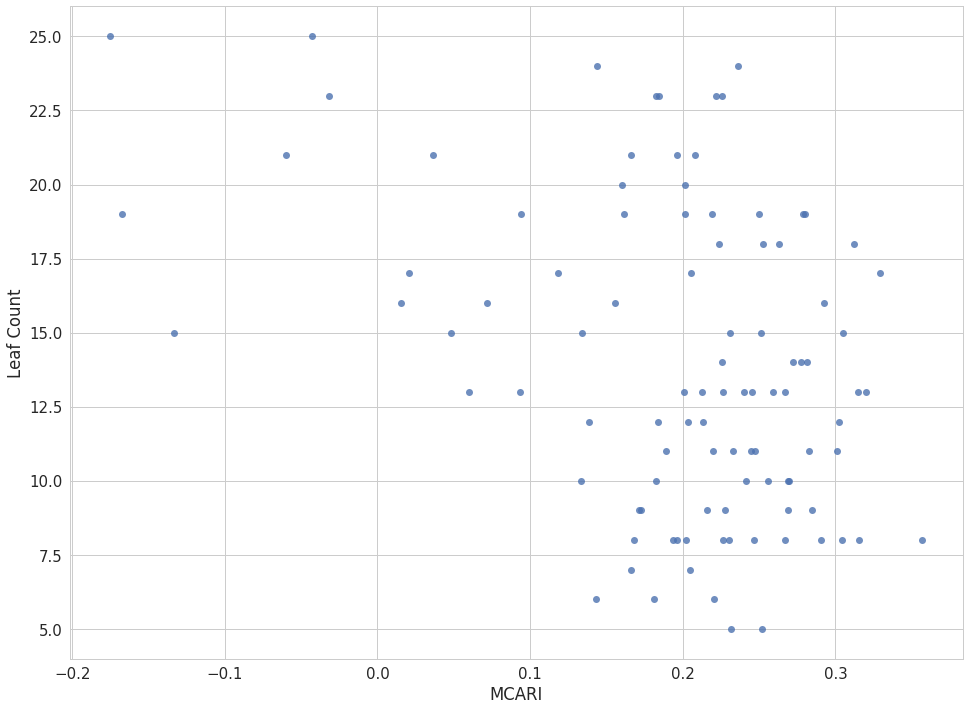

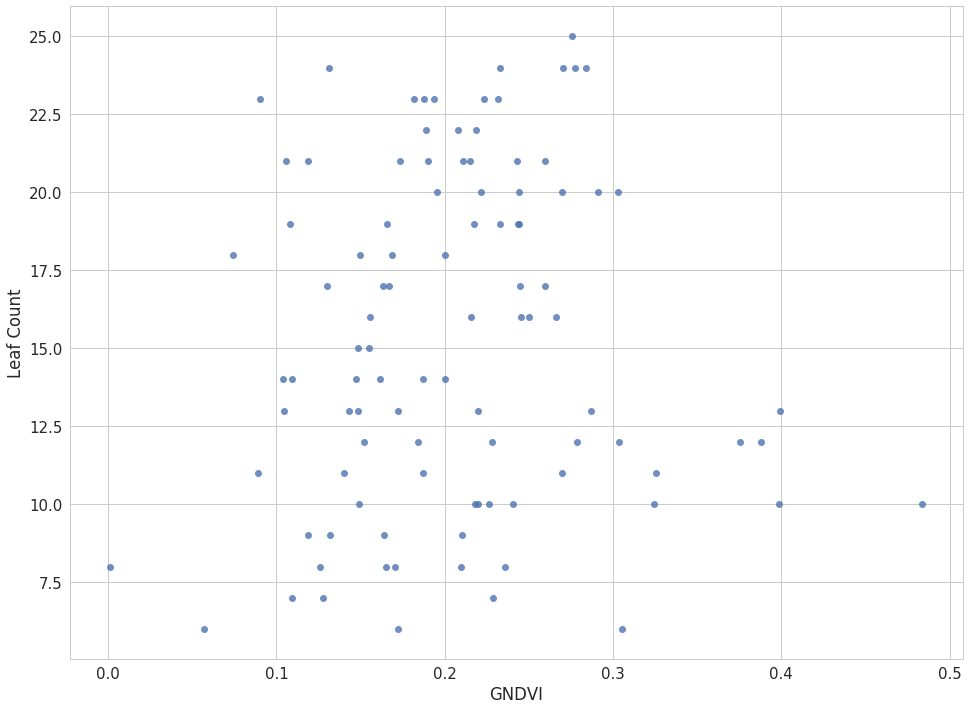

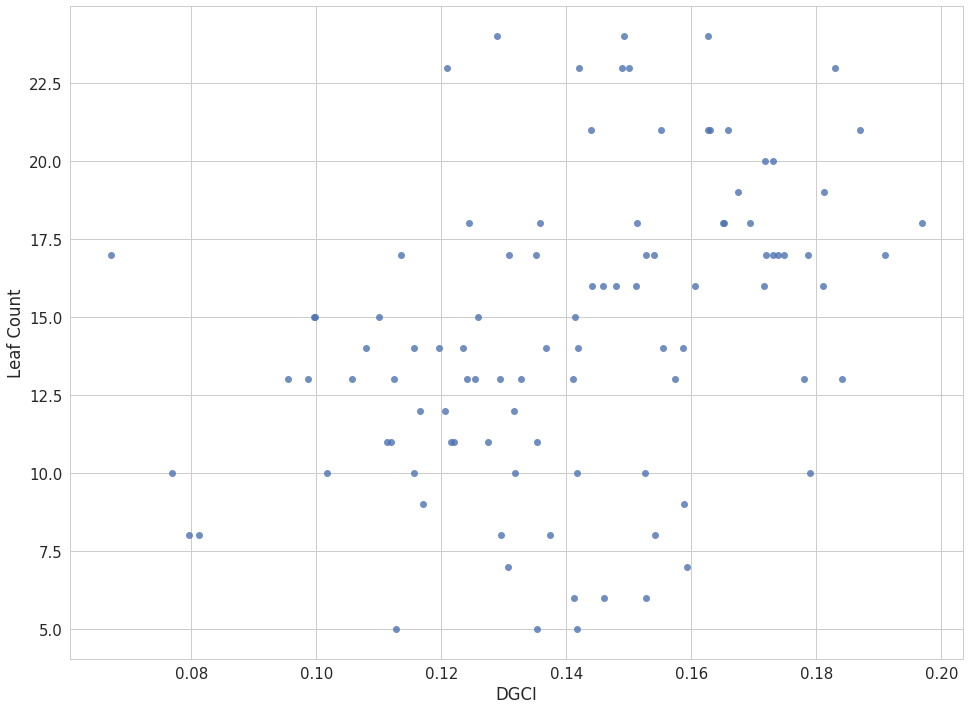

In [48]:
create_scatter(df["UAV_NDVI"], df["Average Leaf Count"], "NDVI", "Leaf Count")
create_scatter(df["RedEdge"], df["Average Leaf Count"], "RedEdge", "Leaf Count")
create_scatter(df["EVI"], df["Average Leaf Count"], "EVI", "Leaf Count")
create_scatter(df["MCARI"], df["Average Leaf Count"], "MCARI", "Leaf Count")
create_scatter(df["GNDVI"], df["Average Leaf Count"], "GNDVI", "Leaf Count")
create_scatter(df["DGCI"], df["Average Leaf Count"], "DGCI", "Leaf Count")

## Analyze distribution of ground truth

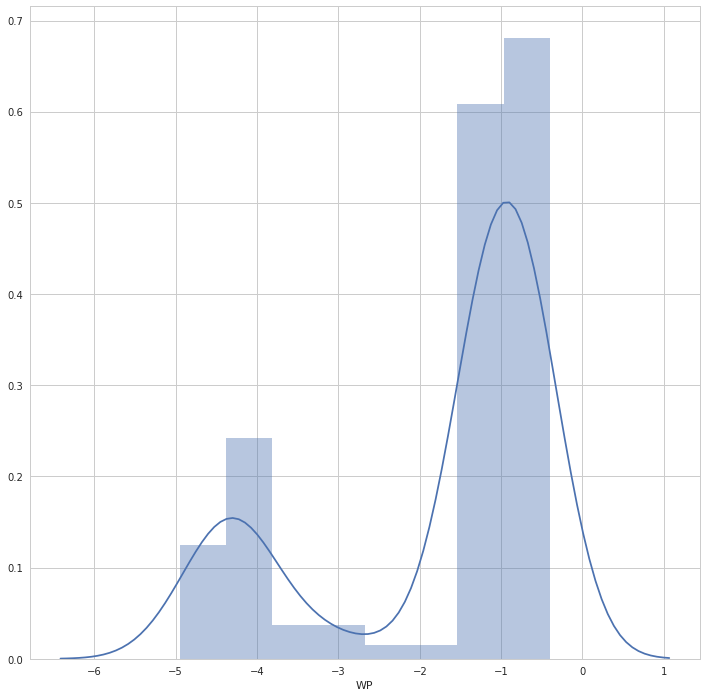

In [24]:
sns.distplot(df["WP"].dropna())

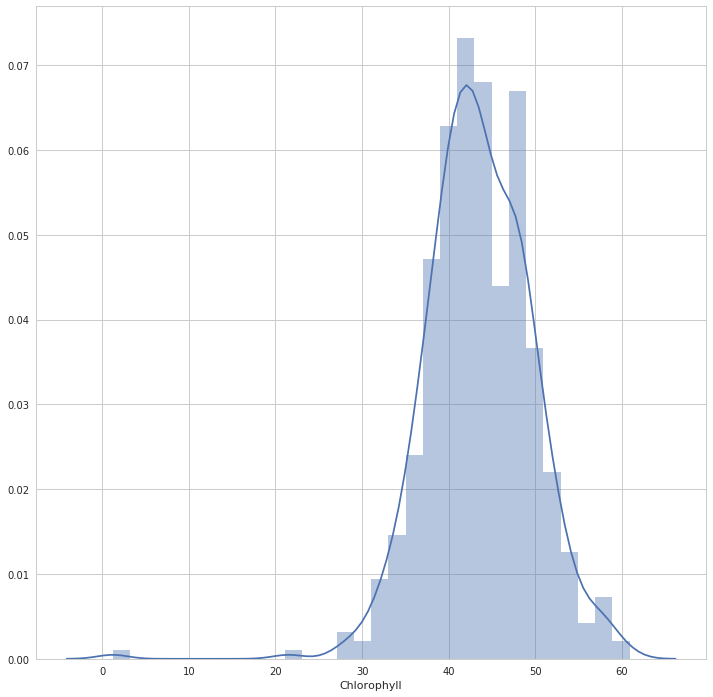

In [25]:
sns.distplot(df["Chlorophyll"])

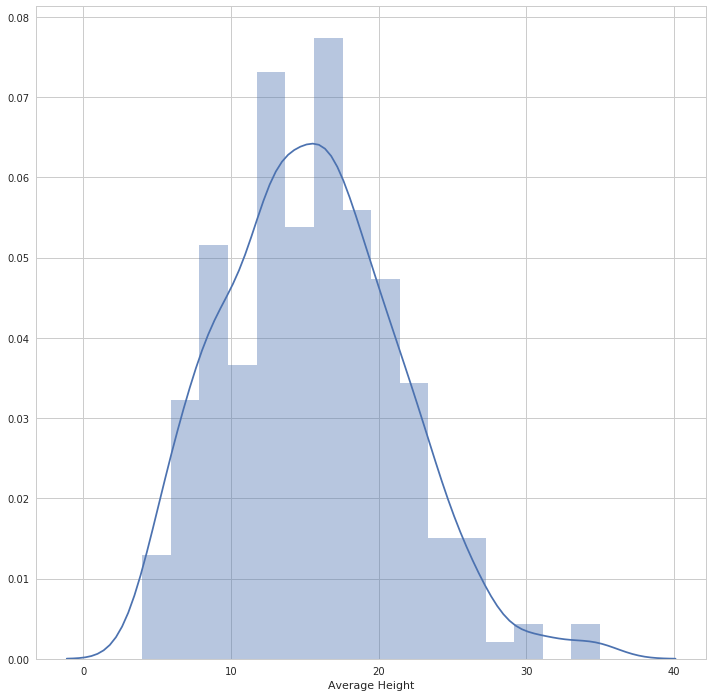

In [26]:
sns.distplot(df["Average Height"])

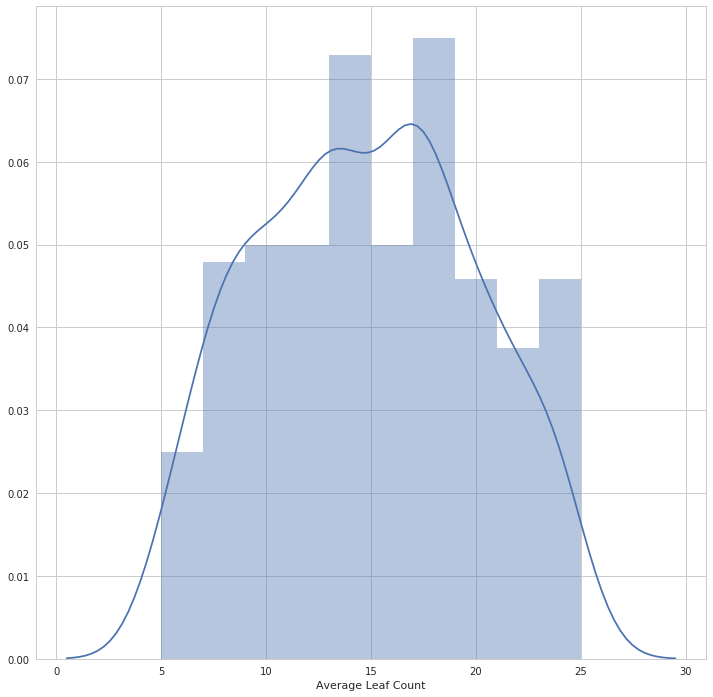

In [27]:
sns.distplot(df["Average Leaf Count"])

## Predictive Models

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import shuffle

In [29]:
def rmse(y, yhat):
    return np.sqrt(np.mean((y - yhat)**2))

def mae(y, yhat):
    return np.mean(np.abs(y - yhat))

def normalize(xs):
    max_x = max(xs)
    min_x = min(xs)
    return [(x-min_x)/(max_x-min_x) for x in xs]

RMSE: 0.32005018360603094
MAE: 0.26235128156973725
R2: 0.009241380258008358


Text(0,0.5,'Predicted WP')

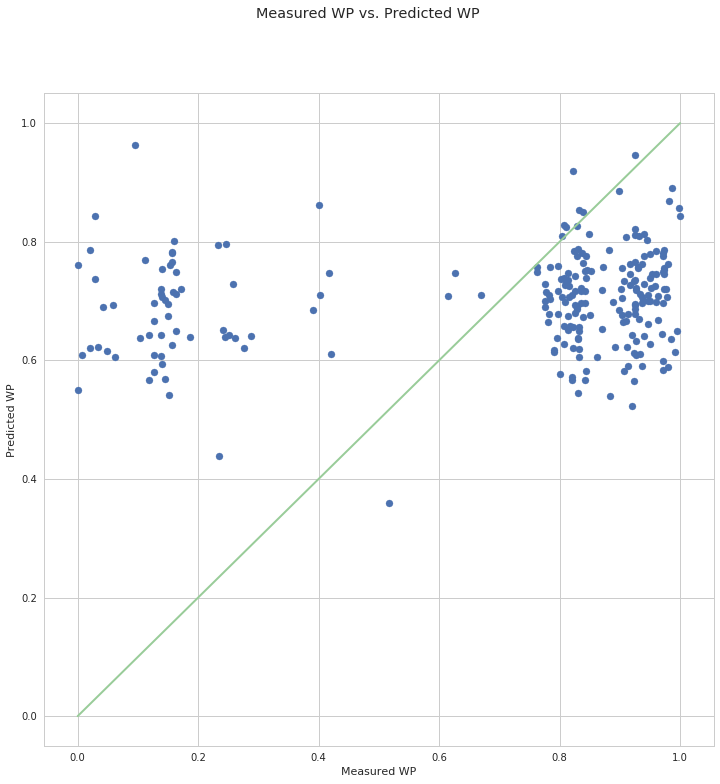

In [30]:
X = np.array(list(df.dropna()["channel_vals"]))
y = np.array(normalize(list(df.dropna()["WP"])))

X, y = shuffle(X, y)

model = Pipeline([("poly", PolynomialFeatures(degree=1)), ("linear", LinearRegression(fit_intercept=False))])
predicted = cross_val_predict(model, X, y, cv=10)
print("RMSE:", rmse(predicted, y))
print("MAE:", mae(predicted, y))
print("R2:", r2_score(y, predicted))

fig = plt.figure()
plt.scatter(y, predicted)
plt.plot(range(2), range(2), color="#99CC99", linewidth=2)
fig.suptitle("Measured WP vs. Predicted WP")
plt.xlabel("Measured WP")
plt.ylabel("Predicted WP")

RMSE: 0.0946189086085815
MAE: 0.07246169544499884
R2: 0.1379437892034332


Text(0,0.5,'Predicted Chlorophyll')

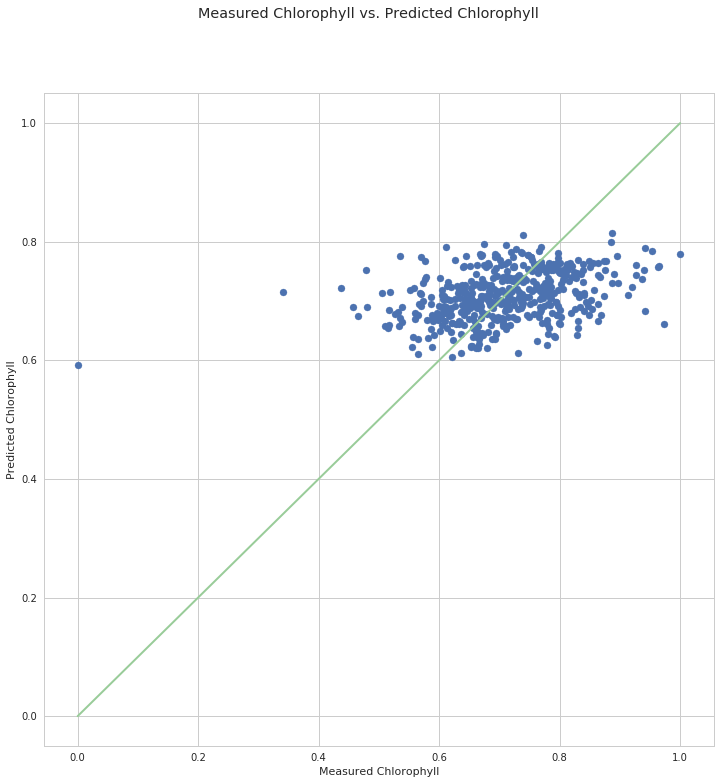

In [35]:
X = np.array(list(df["channel_vals"]))
y = np.array(normalize(list(df["Chlorophyll"])))

X, y = shuffle(X, y)

model = Pipeline([("poly", PolynomialFeatures(degree=1)), ("linear", LinearRegression(fit_intercept=False))])
predicted = cross_val_predict(model, X, y, cv=10)
print("RMSE:", rmse(predicted, y))
print("MAE:", mae(predicted, y))
print("R2:", r2_score(y, predicted))

fig = plt.figure()
plt.scatter(y, predicted)
plt.plot(range(2), range(2), color="#99CC99", linewidth=2)
fig.suptitle("Measured Chlorophyll vs. Predicted Chlorophyll")
plt.xlabel("Measured Chlorophyll")
plt.ylabel("Predicted Chlorophyll")

RMSE: 0.12125570110873829
MAE: 0.09309174268046155
R2: 0.5874380599201059


Text(0,0.5,'Predicted Plant Height')

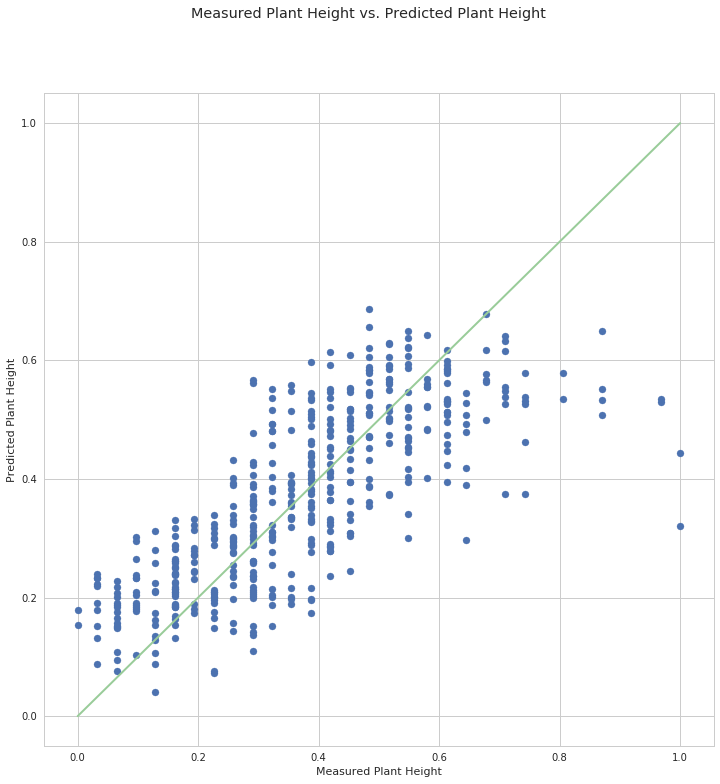

In [32]:
X = np.array(list(df["channel_vals"]))
y = np.array(normalize(list(df["Average Height"])))

X, y = shuffle(X, y)

model = Pipeline([("poly", PolynomialFeatures(degree=1)), ("linear", LinearRegression(fit_intercept=False))])
predicted = cross_val_predict(model, X, y, cv=10)
print("RMSE:", rmse(predicted, y))
print("MAE:", mae(predicted, y))
print("R2:", r2_score(y, predicted))

fig = plt.figure()
plt.scatter(y, predicted)
plt.plot(range(2), range(2), color="#99CC99", linewidth=2)
fig.suptitle("Measured Plant Height vs. Predicted Plant Height")
plt.xlabel("Measured Plant Height")
plt.ylabel("Predicted Plant Height")

RMSE: 0.16802052686536628
MAE: 0.1335933429851272
R2: 0.577064106749279


Text(0,0.5,'Predicted Leaf Count')

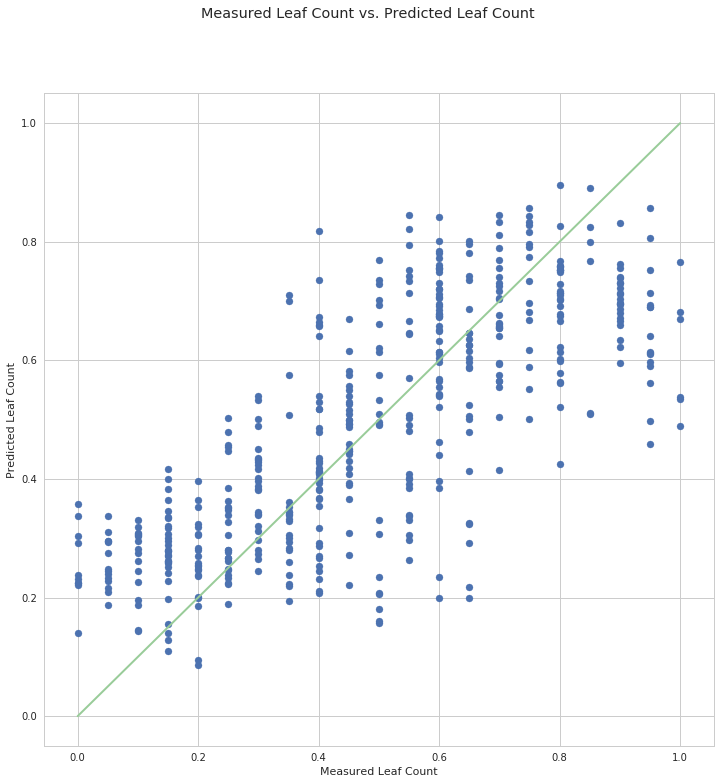

In [33]:
X = np.array(list(df["channel_vals"]))
y = np.array(normalize(list(df["Average Leaf Count"])))

X, y = shuffle(X, y)

model = Pipeline([("poly", PolynomialFeatures(degree=1)), ("linear", LinearRegression(fit_intercept=False))])
predicted = cross_val_predict(model, X, y, cv=10)
print("RMSE:", rmse(predicted, y))
print("MAE:", mae(predicted, y))
print("R2:", r2_score(y, predicted))

fig = plt.figure()
plt.scatter(y, predicted)
plt.plot(range(2), range(2), color="#99CC99", linewidth=2)
fig.suptitle("Measured Leaf Count vs. Predicted Leaf Count")
plt.xlabel("Measured Leaf Count")
plt.ylabel("Predicted Leaf Count")

In [34]:
from sklearn.ensemble import RandomForestClassifier

X = np.array(list(df["channel_vals"]))
y = ["N{}IR{}".format(n, ir) for n, ir in zip(df["Nitrogen"], df["Irrigation"])]

X, y = shuffle(X, y)

model = RandomForestClassifier()
predicted = cross_val_predict(model, X, y, cv=10)
print(np.mean(predicted == y))

0.0625
